# Drive and Imports

In [1]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc,confusion_matrix
from tensorflow.keras import layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras import Model,Sequential
from sklearn.utils import shuffle as skshuffle
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
# from keras import backend as K
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Conv1D,GlobalAveragePooling1D,GlobalMaxPooling1D,Dropout
from plotnine import *
from sklearn.metrics import classification_report


# Data Loading

In [3]:
def data_loader(filepath,label):
  # Load text file
  if not os.path.isfile(filepath):
      print("File path {} does not exist. Exiting...".format(filepath))
  peptides  = []
  labels = []
  with open(filepath,'r',encoding='utf-8-sig') as fp:
    for line in fp:
      # read chars into array as upper chars
      uppercase_line = line.upper()
      peptides.append(uppercase_line.rstrip())
      # add label 0/1
      labels.append(label)
  # random permutations 
  peptides, labels = skshuffle(peptides, labels)
  peptides = np.array(peptides)
  labels = np.array(labels)
  return peptides, labels

In [4]:
SEQ_LEN = 9
VOCAB_SIZE = 20
def create_dict():
  alphabet = "ACDEFGHIKLMNPQRSTVWY"
  #Creates a dict, that maps to every char of alphabet an unique int based on position
  char_dict = dict((c,i) for i,c in enumerate(alphabet))
  return char_dict

def encoder(data):
  # encode data to vector where there are one's wherever the charecter is
    char_dict = create_dict()
    data_encoder = []
    for seq in data:
        # check that sequence length is 9 as required
        if (len(seq) ==  SEQ_LEN):
          # create a vector that represents the sequence
          encoder = np.zeros(SEQ_LEN*VOCAB_SIZE)
          i=0
          for char in seq:
            # check if the charecter is on the vocabulary dictionary
              if char in char_dict.keys():
                    # Add 1 where the charcter is 
                    encoder[i * VOCAB_SIZE + (char_dict[char])]=1
                    i=i+1
              else:
                    print("Char not in vocabulary : ", char)
          data_encoder.append(encoder)
        else:
          print("Sequence length should be 9")    
    return np.array(data_encoder)

# Create Model

In [ ]:
class MyModel(Model):
  # Baseline model
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(20, activation='relu')
    # self.d2 = Dropout(0.5)
    self.d3 = Dense(10, activation='relu')
    # self.outputs = Dense(2, activation='softmax')
    # self.outputs = Dense(2, activation='sigmoid')
    self.outputs = Dense(2, activation='relu')

  def call(self, x):
    x = self.d1(x)
    # x = self.d2(x)
    x = self.d3(x)
    return self.outputs(x)

In [133]:
def train_step(images, labels,loss_object,train_loss,train_accuracy,train_recall,train_precision):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer = tf.keras.optimizers.Adam()
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, predictions)    
  train_recall(labels, tf.argmax(predictions,1)) 
  train_precision(labels, tf.argmax(predictions,1)) 

def test_step(images, labels,loss_object,test_loss,test_accuracy,test_recall,test_precision):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)
  test_loss(t_loss)
  test_accuracy(labels, predictions)
  test_recall(labels, tf.argmax(predictions,1))
  test_precision(labels, tf.argmax(predictions,1))

def final_prediction(precisions):
  ret = []
  for pre_ in precisions:
    ret.append(np.argmax(pre_))
  return ret

Train a model and define metrics

In [132]:
EPOCHS = 25
def train_model():
  train_ds = tf.data.Dataset.from_tensor_slices(
      (encoded_x_train, y_train)).shuffle(10000).batch(32)
  test_ds = tf.data.Dataset.from_tensor_slices((encoded_x_test, y_test)).batch(32)

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  train_recall = tf.keras.metrics.Recall(name='train_recall')
  train_precision = tf.keras.metrics.Precision(name='train_precision')

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  test_recall = tf.keras.metrics.Recall(name='test_recall')
  test_precision = tf.keras.metrics.Precision(name='test_precision')

  test_loss_arr = []
  test_accuracy_arr = []
  train_loss_arr = []
  train_accuracy_arr = []
  for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_recall.reset_states()
    train_precision.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_recall.reset_states()
    test_precision.reset_states()

    for x_t, y_t in train_ds:
      train_step(x_t, y_t,loss_object,train_loss,train_accuracy,train_recall,train_precision)

    for x_v, y_v in test_ds:
      test_step(x_v, y_v,loss_object,test_loss,test_accuracy,test_recall,test_precision)

    print(
      f'Epoch {epoch + 1}, '
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result() * 100}, '
      f'Train Recall: {train_recall.result()},'
      f'Train Precision: {train_precision.result()}'
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result() * 100}'
      f'Test Recall: {test_recall.result()},'
      f'Test Precision: {test_precision.result()}'

    )
    train_accuracy_arr.append(train_accuracy.result())
    train_loss_arr.append(train_loss.result())
    test_accuracy_arr.append(test_accuracy.result())
    test_loss_arr.append(test_loss.result())
  num_of_epoch = np.arange(0,len(train_accuracy_arr))

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(num_of_epoch, np.array(train_accuracy_arr), label="Train accuracy")
  plt.plot(num_of_epoch, np.array(test_accuracy_arr), label="Test accuracy")
  plt.title("Accuracy of Train and Test ")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  # plt.show()

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(num_of_epoch, np.array(train_loss_arr), label="Train Loss")
  plt.plot(num_of_epoch, np.array(test_loss_arr), label="Test Loss")
  plt.title("Loss of Train and Test ")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend()
  # plt.show()

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(num_of_epoch, np.array(train_loss_arr), label="Train Recall")
  plt.plot(num_of_epoch, np.array(test_loss_arr), label="Test Recall")
  plt.title("Recall of Train and Test ")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Recall")
  plt.legend()
  # plt.show()

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(num_of_epoch, np.array(train_loss_arr), label="Train Precision")
  plt.plot(num_of_epoch, np.array(test_loss_arr), label="Test Precision")
  plt.title("Precision of Train and Test ")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Precision")
  plt.legend()
  plt.show()

In [7]:
# Function for calculating the final ROC-AUC score and plot the ROC curve,
def stats(pred, actual):
  plt.figure(figsize=(20, 10))
  fpr1, tpr1, _ = roc_curve(actual[0], pred[0])
  fpr2, tpr2, _ = roc_curve(actual[1], pred[1])
  roc_auc = [auc(fpr1, tpr1), auc(fpr2, tpr2)]
  lw = 2
  plt.plot(fpr1, tpr1, lw=lw, label='Training set (ROC-AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr2, tpr2, lw=lw, label='Validation set (ROC-AUC = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', label = 'Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('Training set vs. Validation set ROC curves')
  plt.legend(loc="lower right", prop = {'size': 20})
  plt.show()


# Results of creating 8 copies of negatice samples

Load data from path. 
Make copies of positive samples so the number of them will be equal to the number of the negative

In [8]:
peptides_p , p = data_loader('/content/gdrive/MyDrive/Deep Learning /Positive/pos_A0201.txt',1)
peptides_n , n = data_loader('/content/gdrive/MyDrive/Deep Learning /Negative/neg_A0201.txt',0)
peptides_p , p = np.tile(peptides_p,8),np.tile(p,8)
peptides = (np.concatenate((peptides_p, peptides_n), axis = 0))
labels = (np.concatenate((p, n), axis = 0))

In [9]:
pos, neg = peptides_p.shape[0] , peptides_n.shape[0]
total = pos + neg
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total,neg, 100 * neg / total))

Examples:
    Total: 48420
    Positive: 23928 (49.42% of total)
    Negative: 24492 (50.58% of total)



Split data to trainset and testset (90%/10%)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(peptides, labels, test_size=0.1, random_state=42)
print(x_train[0])

GVLDTLTKV


Encode data to vectors that represt sequences

In [11]:
encoded_x_train = encoder(x_train)
encoded_x_test = encoder(x_test)

Activation Softmax only Dense 32,16

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(32, activation='relu')
    self.d2 = Dense(16, activation='relu')
    self.outputs = Dense(2, activation='softmax')

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.outputs(x)

Create model, train it and plot ROC curve


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.43768125772476196, Accuracy: 87.6359634399414, Train Recall: 0.9255427718162537,Train Precision: 0.8406084179878235Test Loss: 0.4131401479244232, Test Accuracy: 89.57042694091797Test Recall: 0.9578414559364319,Test Precision: 0.8487112522125244
Epoch 2, Loss: 0.4085801839828491, Accuracy: 90.14640808105469, Train Recall: 0.9428465366363525,Train Precision: 0.8690669536590576Test Loss: 0.4049891531467438, Test Accuracy: 90.47914123535156Test Recall: 0.9435076117515564,Test Precision: 0.8

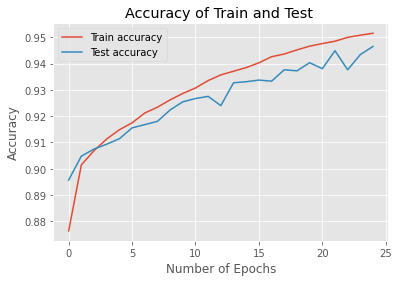

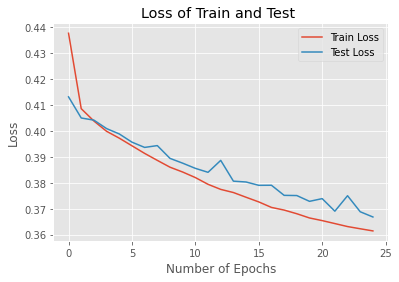

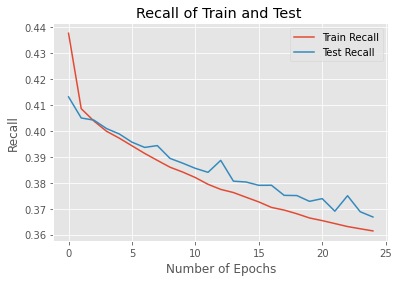

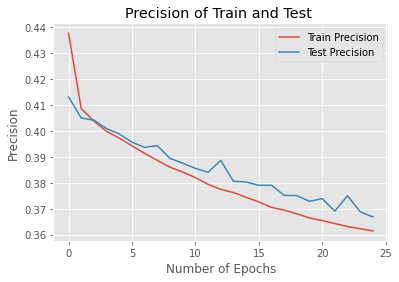

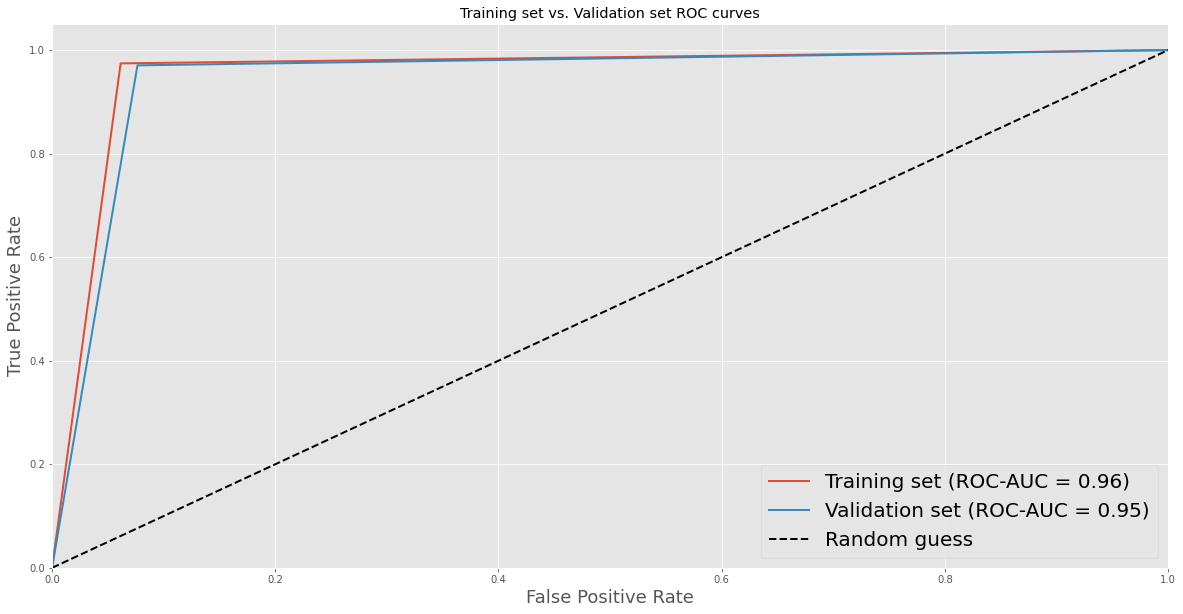

In [ ]:
model = MyModel()
train_model()
train_p, test_p = final_prediction(model.predict(encoded_x_train)), final_prediction(model.predict(encoded_x_test))
pre = [train_p, test_p]
actual_y = [y_train, y_test]
stats(pre, actual_y)

In [ ]:
model.summary()

Model: "my_model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             multiple                  5792      
_________________________________________________________________
dense_73 (Dense)             multiple                  528       
_________________________________________________________________
dense_74 (Dense)             multiple                  34        
Total params: 6,354
Trainable params: 6,354
Non-trainable params: 0
_________________________________________________________________


Classification report

In [ ]:
y_pred_val = model.predict(encoded_x_test, verbose=1)
print(classification_report(y_test, y_pred_val.argmax(1)))

y_pred = model.predict(encoded_x_train, verbose=1)
print(classification_report(y_train, y_pred.argmax(1)))

152/152 [==============================] - 0s 725us/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      2470
           1       0.92      0.97      0.95      2372

    accuracy                           0.95      4842
   macro avg       0.95      0.95      0.95      4842
weighted avg       0.95      0.95      0.95      4842

1362/1362 [==============================] - 1s 724us/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     22022
           1       0.94      0.97      0.96     21556

    accuracy                           0.96     43578
   macro avg       0.96      0.96      0.96     43578
weighted avg       0.96      0.96      0.96     43578



Activation Sigmoid only Dense 32,16

In [33]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(32, activation='relu')
    self.d2 = Dense(16, activation='relu')
    self.outputs = Dense(2, activation='sigmoid')

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.outputs(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.44570258259773254, Accuracy: 87.3973159790039, Train Recall: 0.945722758769989,Train Precision: 0.8250768780708313Test Loss: 0.41304346919059753, Test Accuracy: 89.90087127685547Test Recall: 0.9186340570449829,Test Precision: 0.8804040551185608
Epoch 2, Loss: 0.409390389919281, Accuracy: 90.07756042480469, Train Recall: 0.9428465366363525,Train Precision: 0.8679535388946533Test Loss: 0.408108651638031, Test Accuracy: 89.98347473144531Test Recall: 0.9291737079620361,Test Precision: 0.874

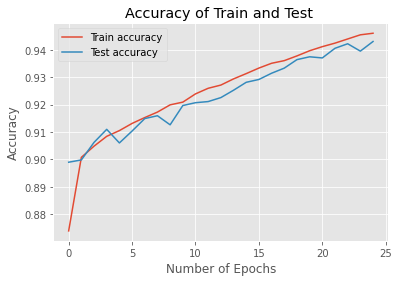

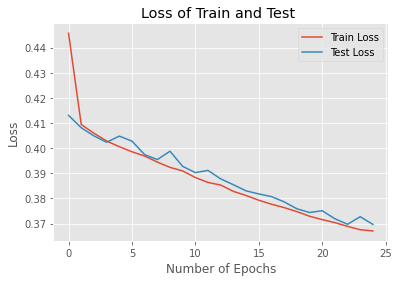

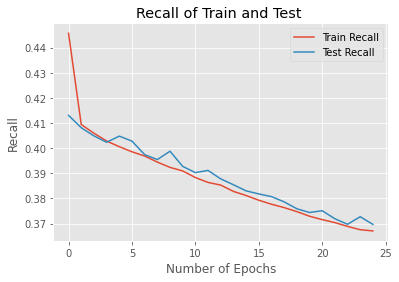

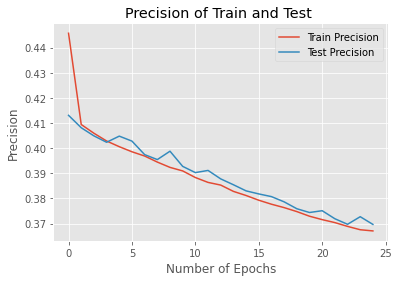

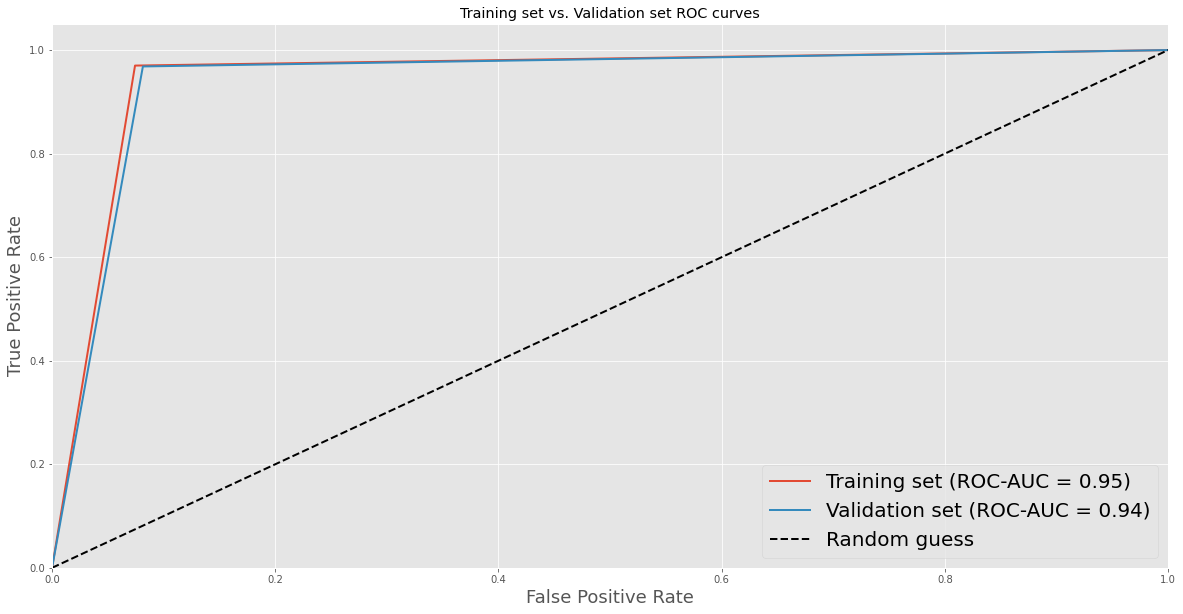

In [35]:
model = MyModel()
train_model()
train_p, test_p = final_prediction(model.predict(encoded_x_train)), final_prediction(model.predict(encoded_x_test))
pre = [train_p, test_p]
actual_y = [y_train, y_test]
stats(pre, actual_y)

In [ ]:
y_pred_val = model.predict(encoded_x_test, verbose=1)
print(classification_report(y_test, y_pred_val.argmax(1)))

y_pred = model.predict(encoded_x_train, verbose=1)
print(classification_report(y_train, y_pred.argmax(1)))

152/152 [==============================] - 0s 847us/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2470
           1       0.92      0.97      0.94      2372

    accuracy                           0.94      4842
   macro avg       0.94      0.94      0.94      4842
weighted avg       0.94      0.94      0.94      4842

1362/1362 [==============================] - 1s 730us/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     22022
           1       0.93      0.97      0.95     21556

    accuracy                           0.95     43578
   macro avg       0.95      0.95      0.95     43578
weighted avg       0.95      0.95      0.95     43578



Activation ReLU only Dense 32,16

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(32, activation='relu')
    self.d2 = Dense(16, activation='relu')
    self.outputs = Dense(2, activation='relu')

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.outputs(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.3125484883785248, Accuracy: 87.14488983154297, Train Recall: 0.9242902398109436,Train Precision: 0.8338494896888733Test Loss: 0.2753218412399292, Test Accuracy: 89.50846862792969Test Recall: 0.9287521243095398,Test Precision: 0.8666404485702515
Epoch 2, Loss: 0.2698879837989807, Accuracy: 89.60255432128906, Train Recall: 0.9421970844268799,Train Precision: 0.8607755899429321Test Loss: 0.26774924993515015, Test Accuracy: 89.7149887084961Test Recall: 0.9481450319290161,Test Precision: 0.8

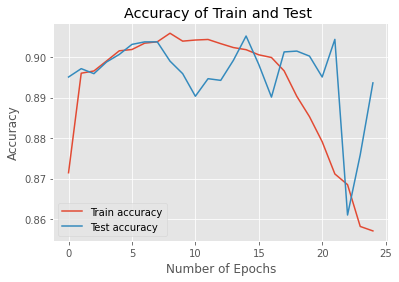

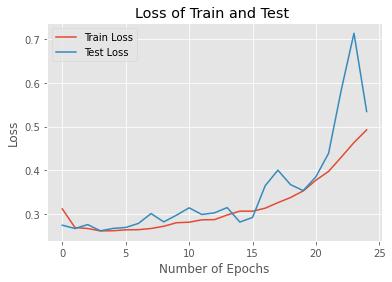

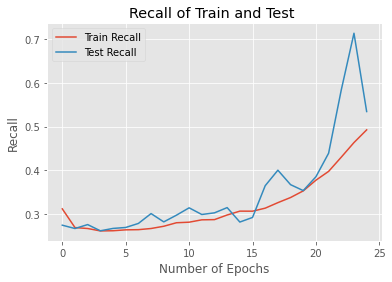

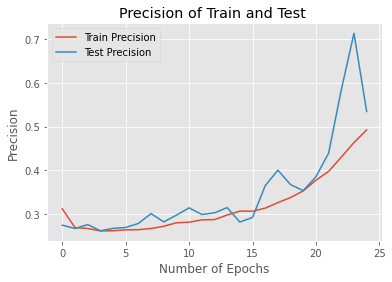

In [ ]:
model = MyModel()
train_model()

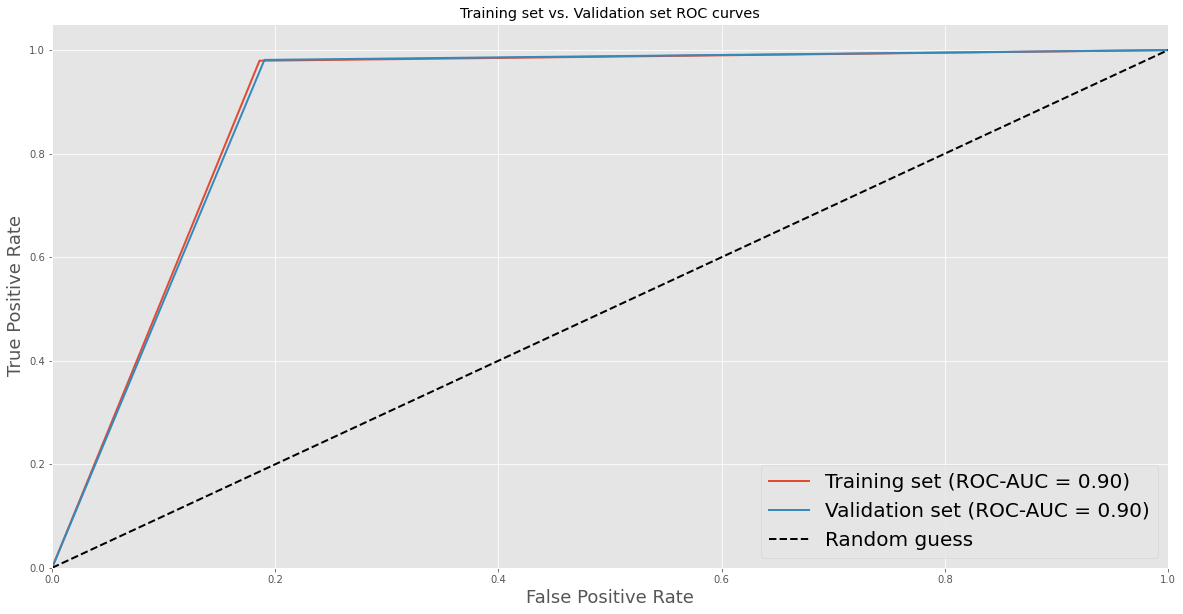

In [ ]:
train_p, test_p = final_prediction(model.predict(encoded_x_train)), final_prediction(model.predict(encoded_x_test))
pre = [train_p, test_p]
actual_y = [y_train, y_test]
stats(pre, actual_y)

In [ ]:
y_pred_val = model.predict(encoded_x_test, verbose=1)
print(classification_report(y_test, y_pred_val.argmax(1)))

y_pred = model.predict(encoded_x_train, verbose=1)
print(classification_report(y_train, y_pred.argmax(1)))

152/152 [==============================] - 0s 718us/step
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      2470
           1       0.83      0.98      0.90      2372

    accuracy                           0.89      4842
   macro avg       0.90      0.90      0.89      4842
weighted avg       0.91      0.89      0.89      4842

1362/1362 [==============================] - 1s 720us/step
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     22022
           1       0.84      0.98      0.90     21556

    accuracy                           0.90     43578
   macro avg       0.91      0.90      0.90     43578
weighted avg       0.91      0.90      0.90     43578



# Compare

In [ ]:
peptides_p , p = data_loader('/content/gdrive/MyDrive/Deep Learning /Positive/pos_A0201.txt',1)
peptides_n , n = data_loader('/content/gdrive/MyDrive/Deep Learning /Negative/neg_A0201.txt',0)
peptides = (np.concatenate((peptides_p, peptides_n), axis = 0))
labels = (np.concatenate((p, n), axis = 0))

In [ ]:
pos, neg = peptides_p.shape[0] , peptides_n.shape[0]
total = pos + neg
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total,neg, 100 * neg / total))

Examples:
    Total: 27483
    Positive: 2991 (10.88% of total)
    Negative: 24492 (89.12% of total)



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(peptides, labels, test_size=0.1, random_state=42)
print(x_train[0])

ALLVRLQEV


In [ ]:
encoded_x_train = encoder(x_train)
encoded_x_test = encoder(x_test)

Dropout Activation softmax

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dropout(0.5)
    self.d3 = Dense(32, activation='relu')
    self.outputs = Dense(2, activation='softmax')

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return self.outputs(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.42823663353919983, Accuracy: 88.7118911743164, Train Recall: 0.004053058102726936,Train Precision: 0.10999999940395355Test Loss: 0.4140658378601074, Test Accuracy: 89.9236068725586Test Recall: 0.0,Test Precision: 0.0
Epoch 2, Loss: 0.4226134717464447, Accuracy: 89.02725219726562, Train Recall: 0.0,Train Precision: 0.0Test Loss: 0.4132049083709717, Test Accuracy: 89.9236068725586Test Recall: 0.0,Test Precision: 0.0
Epoch 3, Loss: 0.4209909737110138, Accuracy: 89.02725219726562, Train Rec

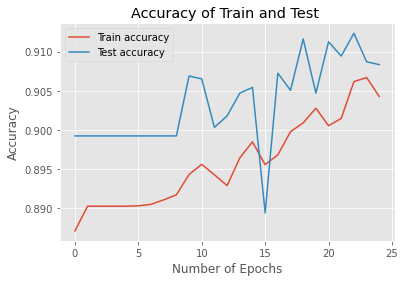

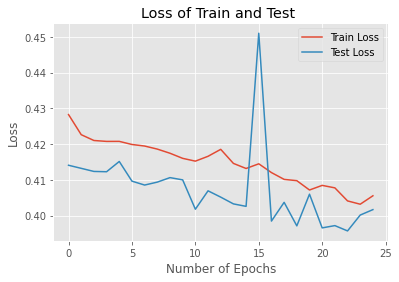

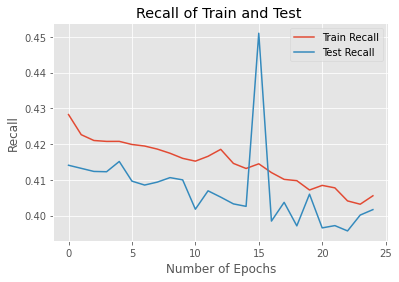

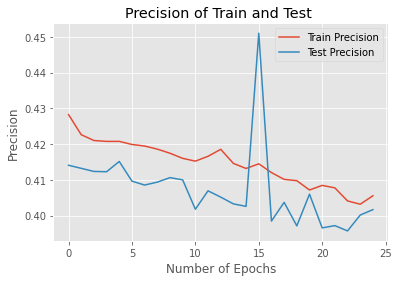

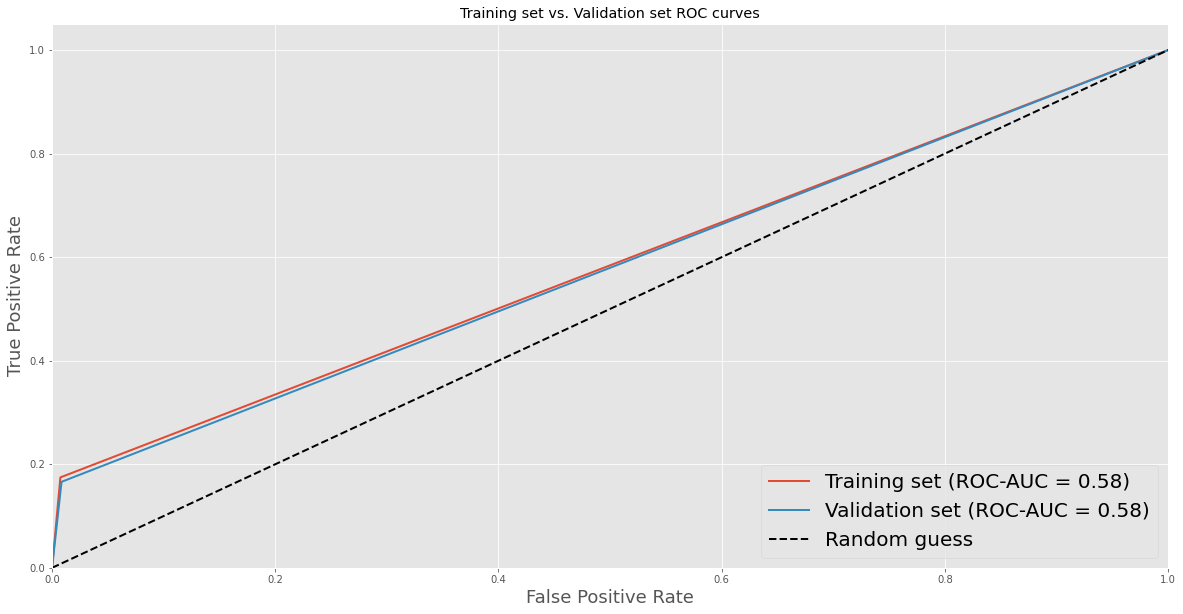

In [ ]:
model = MyModel()
train_model()
train_p, test_p = final_prediction(model.predict(encoded_x_train)), final_prediction(model.predict(encoded_x_test))
pre = [train_p, test_p]
actual_y = [y_train, y_test]
stats(pre, actual_y)

In [ ]:
model.summary()

Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  23168     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  4128      
_________________________________________________________________
dense_8 (Dense)              multiple                  66        
Total params: 27,362
Trainable params: 27,362
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.metrics import classification_report

y_pred_val = model.predict(encoded_x_test, verbose=1)
print(classification_report(y_test, y_pred_val.argmax(1)))

y_pred = model.predict(encoded_x_train, verbose=1)
print(classification_report(y_train, y_pred.argmax(1)))

86/86 [==============================] - 0s 827us/step
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2472
           1       0.69      0.17      0.27       277

    accuracy                           0.91      2749
   macro avg       0.80      0.58      0.61      2749
weighted avg       0.89      0.91      0.88      2749

773/773 [==============================] - 1s 673us/step
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     22020
           1       0.74      0.17      0.28      2714

    accuracy                           0.90     24734
   macro avg       0.82      0.58      0.62     24734
weighted avg       0.89      0.90      0.87     24734



In [ ]:
print("Train Confusion Matrix: ",confusion_matrix(y_train, y_pred.argmax(1)))
print("Validation Confusion Matrix: ",confusion_matrix(y_test,y_pred_val.argmax(1)))

Train Confusion Matrix:  [[21856   164]
 [ 2240   474]]
Validation Confusion Matrix:  [[2451   21]
 [ 231   46]]


Activation Softmax only Dense 128, 32

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(32, activation='relu')
    self.outputs = Dense(2, activation='softmax')


  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.outputs(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.42133504152297974, Accuracy: 88.8776626586914, Train Recall: 0.030582167208194733,Train Precision: 0.4088670015335083Test Loss: 0.40258878469467163, Test Accuracy: 90.9785385131836Test Recall: 0.24548736214637756,Test Precision: 0.6355140209197998
Epoch 2, Loss: 0.40067946910858154, Accuracy: 90.75362396240234, Train Recall: 0.3319823145866394,Train Precision: 0.6552727222442627Test Loss: 0.3955967426300049, Test Accuracy: 91.5969467163086Test Recall: 0.4368230998516083,Test Precision: 

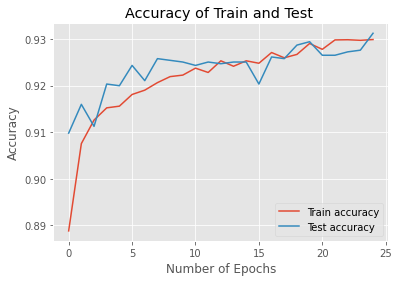

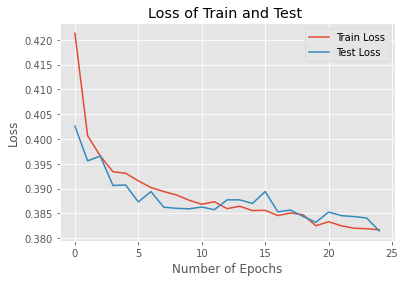

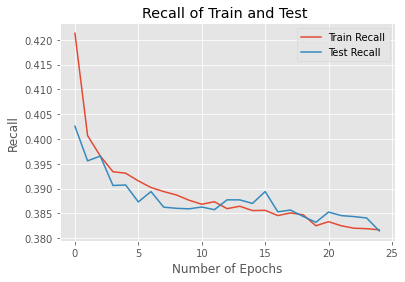

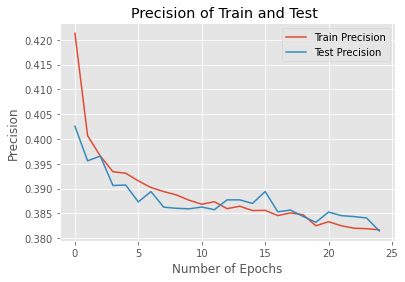

In [ ]:
model = MyModel()
train_model()

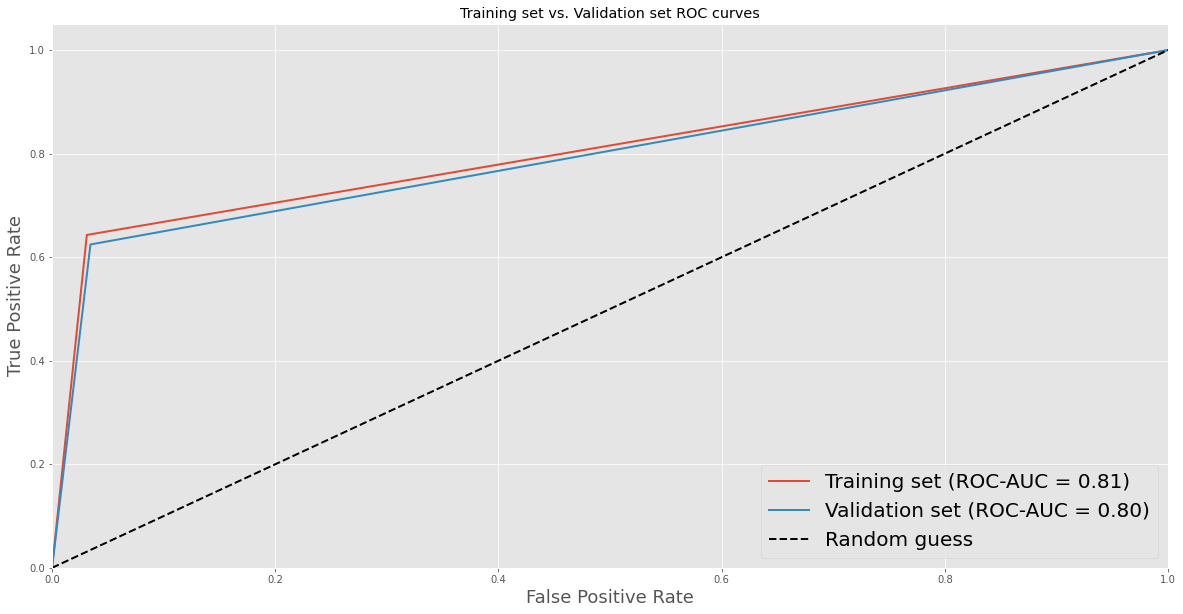

In [ ]:
train_p, test_p = final_prediction(model.predict(encoded_x_train)), final_prediction(model.predict(encoded_x_test))
pre = [train_p, test_p]
actual_y = [y_train, y_test]
stats(pre, actual_y)

In [ ]:
model.summary()

Model: "my_model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             multiple                  23168     
_________________________________________________________________
dense_85 (Dense)             multiple                  4128      
_________________________________________________________________
dense_86 (Dense)             multiple                  66        
Total params: 27,362
Trainable params: 27,362
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred_val = model.predict(encoded_x_test, verbose=1)
print(classification_report(y_test, y_pred_val.argmax(1)))

y_pred = model.predict(encoded_x_train, verbose=1)
print(classification_report(y_train, y_pred.argmax(1)))

86/86 [==============================] - 0s 797us/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2472
           1       0.67      0.62      0.65       277

    accuracy                           0.93      2749
   macro avg       0.81      0.80      0.80      2749
weighted avg       0.93      0.93      0.93      2749

773/773 [==============================] - 1s 835us/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22020
           1       0.72      0.64      0.68      2714

    accuracy                           0.93     24734
   macro avg       0.84      0.81      0.82     24734
weighted avg       0.93      0.93      0.93     24734



Activation Softmax only Dense 32,16

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(32, activation='relu')
    self.d2 = Dense(16, activation='relu')
    self.outputs = Dense(2, activation='softmax')


  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.outputs(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.4277685284614563, Accuracy: 88.67550659179688, Train Recall: 0.002947678789496422,Train Precision: 0.0776699036359787Test Loss: 0.4048505425453186, Test Accuracy: 89.9599838256836Test Recall: 0.014440433122217655,Test Precision: 0.5714285969734192
Epoch 2, Loss: 0.4033500850200653, Accuracy: 90.24420166015625, Train Recall: 0.19933676719665527,Train Precision: 0.6927016377449036Test Loss: 0.3967486023902893, Test Accuracy: 91.4150619506836Test Recall: 0.2779783308506012,Test Precision: 

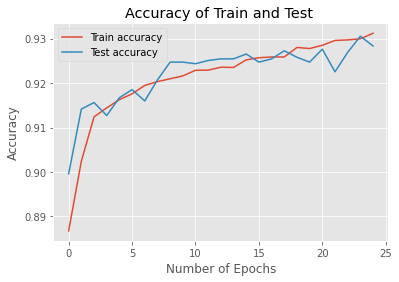

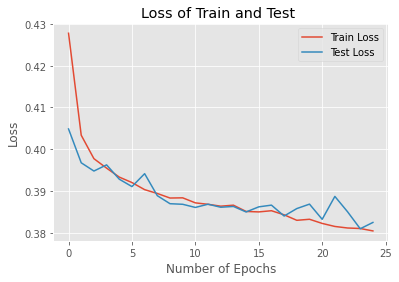

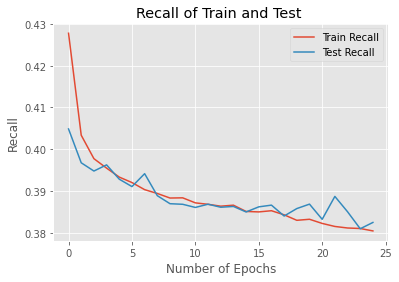

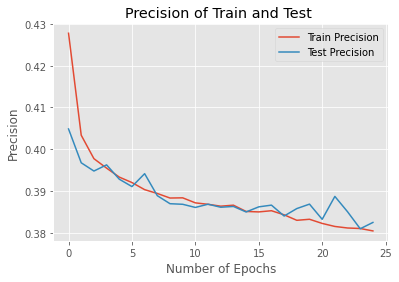

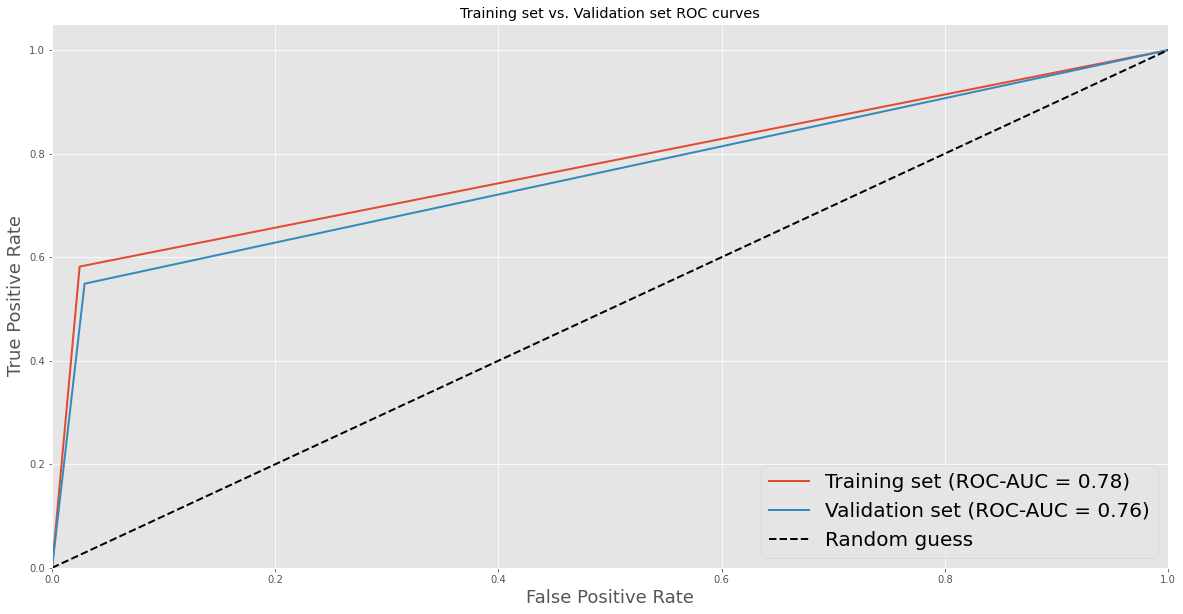

In [ ]:
model = MyModel()
train_model()
train_p, test_p = final_prediction(model.predict(encoded_x_train)), final_prediction(model.predict(encoded_x_test))
pre = [train_p, test_p]
actual_y = [y_train, y_test]
stats(pre, actual_y)

In [ ]:
model.summary()

Model: "my_model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             multiple                  5792      
_________________________________________________________________
dense_88 (Dense)             multiple                  528       
_________________________________________________________________
dense_89 (Dense)             multiple                  34        
Total params: 6,354
Trainable params: 6,354
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred_val = model.predict(encoded_x_test,  verbose=1)
print(classification_report(y_test, y_pred_val.argmax(1)))

y_pred = model.predict(encoded_x_train,  verbose=1)
print(classification_report(y_train, y_pred.argmax(1)))

86/86 [==============================] - 0s 967us/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2472
           1       0.68      0.55      0.61       277

    accuracy                           0.93      2749
   macro avg       0.81      0.76      0.78      2749
weighted avg       0.92      0.93      0.92      2749

773/773 [==============================] - 1s 703us/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     22020
           1       0.74      0.58      0.65      2714

    accuracy                           0.93     24734
   macro avg       0.85      0.78      0.81     24734
weighted avg       0.93      0.93      0.93     24734



# Best model

Softmax 128 32

In [12]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(32, activation='relu')
    self.outputs = Dense(2, activation='softmax')


  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.outputs(x)

Epoch 1, Loss: 0.4259058072528475, Accuracy: 88.81545734086006, Train Recall: 0.9334292076452032,Train Precision: 0.8540322580645161Test Loss: 0.40556966042832326, Test Accuracy: 90.39653035935564Test Recall: 0.9633220910623946,Test Precision: 0.8580548253849043
Epoch 2, Loss: 0.4032976778111969, Accuracy: 90.81417228876957, Train Recall: 0.9485062163666729,Train Precision: 0.8760443892197609Test Loss: 0.4036670486001592, Test Accuracy: 90.80958281701777Test Recall: 0.9768128161888702,Test Precision: 0.8559290727742889
Epoch 3, Loss: 0.39663397810707707, Accuracy: 91.52324567442287, Train Recall: 0.9513824457227686,Train Precision: 0.88572168955688Test Loss: 0.39094177515883194, Test Accuracy: 92.09004543577034Test Recall: 0.9713322091062394,Test Precision: 0.8797250859106529
Epoch 4, Loss: 0.3910508599575396, Accuracy: 92.13823488916427, Train Recall: 0.9532844683614771,Train Precision: 0.8946795541623128Test Loss: 0.38641109199900375, Test Accuracy: 92.2965716646014Test Recall: 0.940

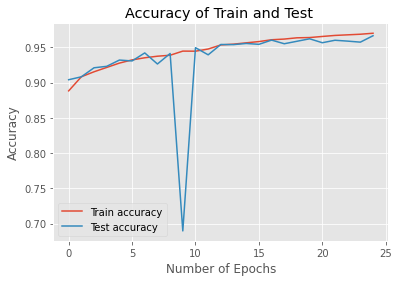

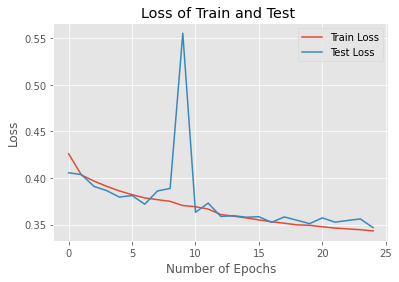

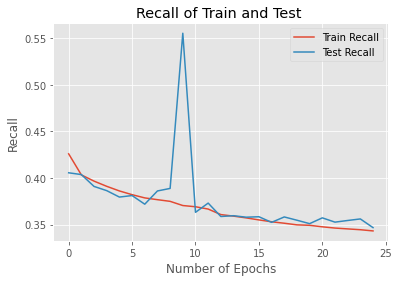

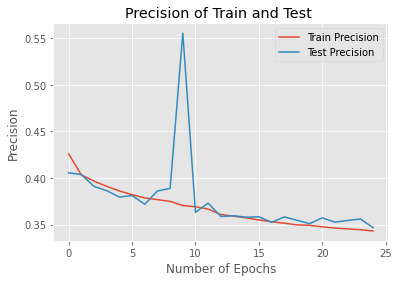

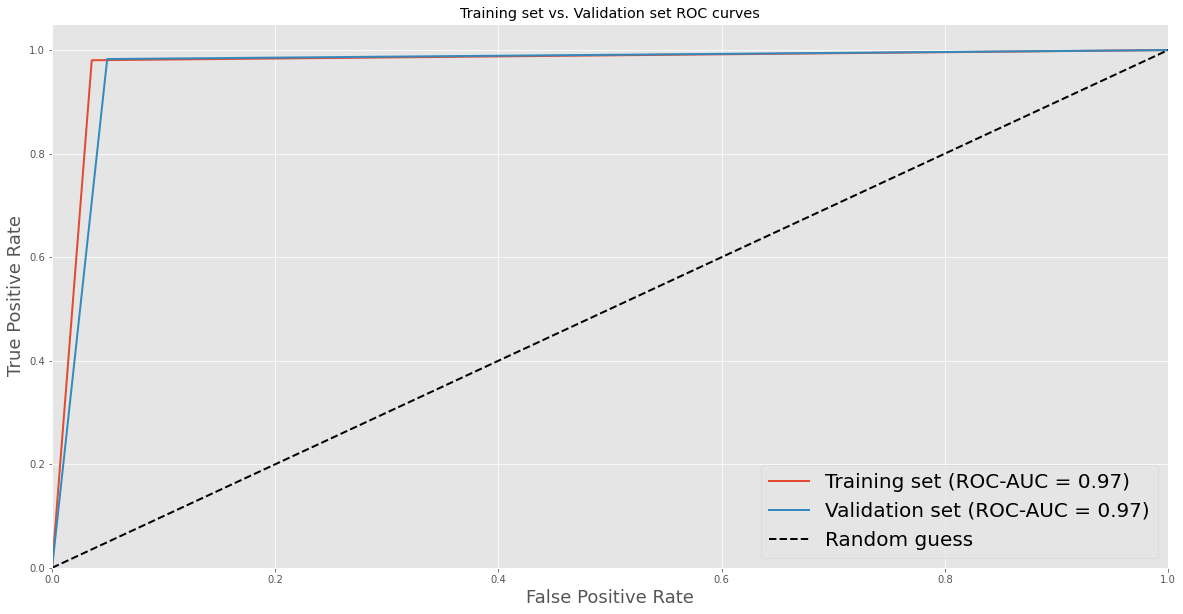

In [13]:
tf.keras.backend.set_floatx('float64')
model = MyModel()
train_model()
train_p, test_p = final_prediction(model.predict(encoded_x_train)), final_prediction(model.predict(encoded_x_test))
pre = [train_p, test_p]
actual_y = [y_train, y_test]
stats(pre, actual_y)

Sigmoid

In [130]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(32, activation='relu')
    self.outputs = Dense(2, activation='sigmoid')


  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.outputs(x)

Epoch 1, Loss: 0.4310653667442949, Accuracy: 88.18669971086328, Train Recall: 0.9413156429764334,Train Precision: 0.8393728799536693Test Loss: 0.40519214421510696, Test Accuracy: 90.85088806278398Test Recall: 0.9388701517706577,Test Precision: 0.881980198019802
Epoch 2, Loss: 0.40482581337905665, Accuracy: 90.62600394694572, Train Recall: 0.9459547225830395,Train Precision: 0.8747372485092875Test Loss: 0.39887582765598045, Test Accuracy: 91.2639405204461Test Recall: 0.9532040472175379,Test Precision: 0.8787407695297318
Epoch 3, Loss: 0.39896737570804647, Accuracy: 91.2616457845702, Train Recall: 0.9497587678604564,Train Precision: 0.8825329769807742Test Loss: 0.39620996168569517, Test Accuracy: 91.73895084675753Test Recall: 0.9405564924114671,Test Precision: 0.8959839357429719
Epoch 4, Loss: 0.3932338304894261, Accuracy: 91.9156455092019, Train Recall: 0.9543050658749304,Train Precision: 0.8901726600025964Test Loss: 0.39435434596318947, Test Accuracy: 91.78025609252374Test Recall: 0.97

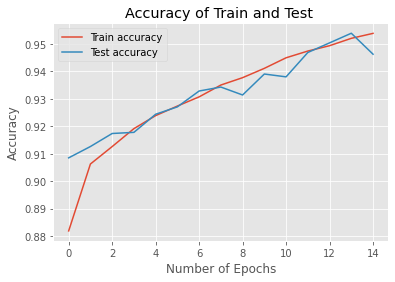

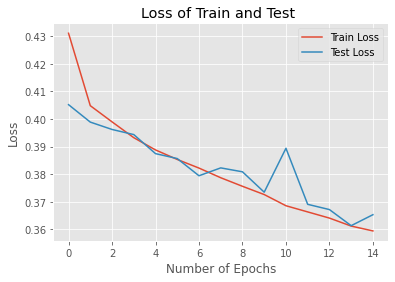

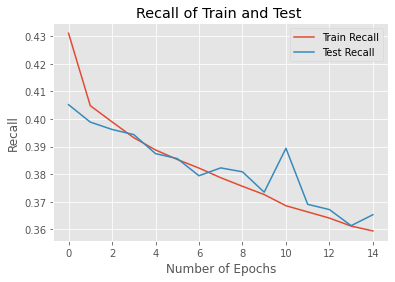

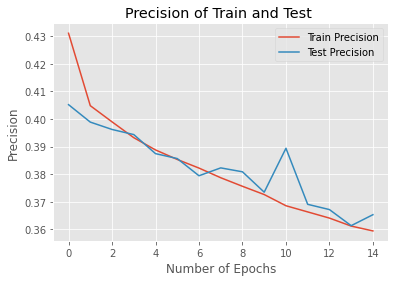

In [134]:
EPOCHS = 15
tf.keras.backend.set_floatx('float64')
model = MyModel()
train_model()
train_p, test_p = model.predict(encoded_x_train), model.predict(encoded_x_test)

In [136]:
print("Train Confusion Matrix: ",confusion_matrix(y_train, train_p.argmax(1)))
print("Validation Confusion Matrix: ",confusion_matrix(y_test,test_p.argmax(1)))

Train Confusion Matrix:  [[20476  1546]
 [  517 21039]]
Validation Confusion Matrix:  [[2261  209]
 [  51 2321]]


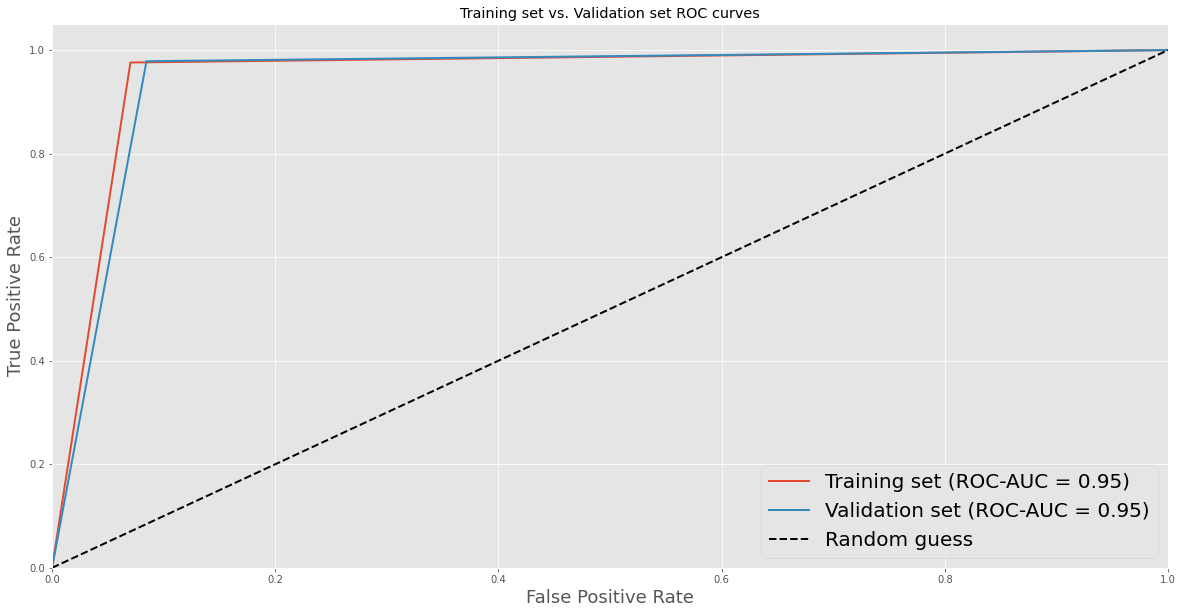

In [137]:
pre = [train_p.argmax(1), test_p.argmax(1)]
actual_y = [y_train, y_test]
stats(pre, actual_y)

# Test

In [185]:
pip install Bio

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 14.1MB 305kB/s 
     |████████████████████████████████| 2.3MB 46.3MB/s 


Read fasta file and write it to output file to predict on

In [244]:
def split_to_9(i,seq):
  # Split a sequence to sequences of length 9
  tep_buf = ""
  for j in range(9):
    tep_buf += seq[i+j]
    out_file.write(str(tep_buf))
  out_file.write('\n')

In [245]:
from Bio import SeqIO
def create_output_file(input_file,output_file):
  # Read fasta to a text file where on each line there is a 9 length sequence
  fasta_sequences = SeqIO.parse(open(input_file),'fasta')
  with open(output_file,'w') as out_file:
    for record in fasta_sequences:
      seq = record.seq
      for i in range(len(seq)-9):
        split_to_9(i,seq)


In [ ]:
input_file = '/content/gdrive/MyDrive/Deep Learning /P0DTC2.fasta'
output_file = '/content/gdrive/MyDrive/Deep Learning /new_test.txt'
create_output_file(input_file,output_file)

Load file with test samples 

In [142]:
test ,l = data_loader('/content/gdrive/MyDrive/Deep Learning /new_test_try.txt',0)

In [152]:
print("number of samples is" , test.shape[0])

number of samples is 1264


Check that there are no dupicates

In [144]:
unique_test = np.unique(test)
print(unique_test.shape)
print(unique_test)

(1264,)
['AAAYYVGYL' 'AAEIRASAN' 'AALQIPFAM' ... 'YYHKNNKSW' 'YYPDKVFRS'
 'YYVGYLQPR']


Encode test set to a vector 

In [145]:
encoded_test = encoder(unique_test)

Use the model to predict whether it is positive or negative

In [146]:
pred = model.predict(encoded_test)

Number of samples that were predicted as positive

In [149]:
np.sum(pred.argmax(1))

38

Number of samples that were predicted as negative

In [150]:
arr.shape[0]-np.sum(pred.argmax(1))

1226

 The top 5 scoring peptides 

In [148]:
idx = np.argsort(pred[:,0],axis=0)
seq_sorted_by_prob= test[idx]
top_5_prob=seq_sorted_by_prob[-5:][::-1]
top_5_prob

array(['TNGTKRFDN', 'LTVLPPLLT', 'VEQDKNTQE', 'GWTFGAGAA', 'NFRVQPTES'],
      dtype='<U9')